#  1. Preparation

### 1.1. Arranging Working Directory

In [1]:
import os
# Show previuos working directory
print("Previuos working dir: " + os.getcwd())
# Change working directory as main project directory
os.chdir("..")
# Show current working directory
print("Current working dir: " + os.getcwd())

Previuos working dir: C:\Users\FCA\Documents\Projects\Github\face-recognition-app-tutorial\tutorial
Current working dir: C:\Users\FCA\Documents\Projects\Github\face-recognition-app-tutorial


### 1.2. Importing Required Packages

In [42]:
# Disable tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('INFO')

import cv2 # OpenCV for image editing, computer vision and deep learning
import imutils # Library used for easier image path handling
import pickle # Library for exporting trained models and embedding vectors
from sklearn.preprocessing import LabelEncoder # For easier label handling
import requests # Library for sending post/get requests to rest api's
import numpy as np # Numpy for math/array operations
from random import randint # For random integer generation

from matplotlib import pyplot as plt # Matplotlib for visualization
from source.utils import plot_image # Custom function for plotting images in jupyter
from source.utils import draw_rectangles # Custom function for drawing detection rectangles

# Importing keras modiles for multi layer perceptron training
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
# Importing support vector machine classifier class
from sklearn.svm import SVC 
# Importing naive bayes classifier class
from sklearn.naive_bayes import GaussianNB 

plt.rcParams["figure.figsize"] = (10, 10) # (w, h) # Figure size arrangement

# 2. Understanding the dataset

### 2.1. Visualize raw training images

In [3]:
# Get raw LOTR training images directory
raw_image_dir = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "raw"

# Print raw LOTR training images directory
print("Raw LOTR training images directory: " + raw_image_dir + "\n")

# Get list of raw LOTR training images
list_of_raw_images = os.listdir(raw_image_dir)

# Print list of raw LOTR training images
print("List of raw LOTR training images: \n" + str(list_of_raw_images))

Raw LOTR training images directory: images\lotr\train\raw

List of raw LOTR training images: 
['aragorn1.jpg', 'aragorn13.jpg', 'aragorn14.jpg', 'aragorn2.jpg', 'aragorn3.jpg', 'aragorn4.jpg', 'aragorn5.jpg', 'aragorn6.jpg', 'aragorn7.jpg', 'aragorn8.jpg', 'aragorn9.jpg', 'arwen1.jpg', 'arwen11.jpg', 'arwen2.jpg', 'arwen3.jpg', 'elrond1.jpg', 'elrond2.jpg', 'elrond3.jpg', 'eowyn1.jpg', 'eowyn11.jpg', 'eowyn12.jpg', 'eowyn14.jpg', 'eowyn2.jpg', 'frodo1.jpg', 'frodo11.jpg', 'frodo13.jpg', 'frodo14.jpg', 'frodo15.jpg', 'frodo3.jpg', 'frodo5.jpg', 'gandalf1.jpg', 'gandalf12.jpg', 'gandalf14.jpg', 'gandalf2.jpg', 'gandalf3.jpg', 'gandalf4.jpg', 'gandalf5.jpg', 'gimli1.jpg', 'gimli11.jpg', 'gimli12.jpg', 'gimli13.jpg', 'gimli2.jpg', 'gimli3.jpg', 'gimli4.jpg', 'gollum1.jpg', 'gollum11.jpg', 'gollum12.jpg', 'gollum13.jpg', 'gollum15.jpg', 'gollum2.jpg', 'gollum3.jpg', 'gollum5.jpg', 'gollum6.jpg', 'legolas1.jpg', 'legolas13.jpg', 'legolas14.jpg', 'legolas2.jpg', 'legolas3.jpg', 'legolas4.jpg'

Selected image path: images\lotr\train\raw\eowyn1.jpg


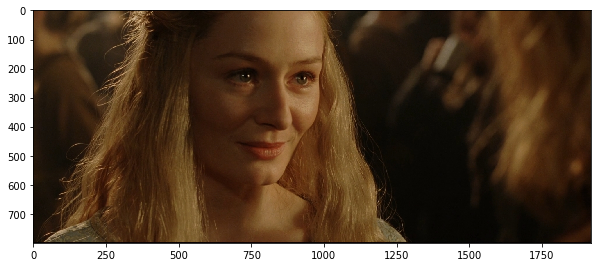

In [7]:
# Randomly select one of raw LOTR training images
random_training_image_path = raw_image_dir + os.sep + list_of_raw_images[randint(0,len(list_of_raw_images)-1)]

# Print selected image path
print("Selected image path: " + random_training_image_path)

# Read selected image
image = cv2.imread(random_training_image_path)

# Visualize selected image
plot_image(image)

### Visualize raw testing images

In [8]:
# Get raw LOTR testing images directory
raw_image_dir = "images" + os.sep + "lotr" + os.sep + "test" + os.sep + "raw"

# Print raw LOTR testing images directory
print("Raw LOTR training images directory: " + raw_image_dir + "\n")

# Get list of raw LOTR testing images
list_of_raw_images = os.listdir(raw_image_dir)

# Print list of raw LOTR testing images
print("List of raw LOTR training images: \n" + str(list_of_raw_images))

Raw LOTR training images directory: images\lotr\test\raw

List of raw LOTR training images: 
['aragorn10.jpg', 'aragorn11.jpg', 'aragorn12.jpg', 'arwen4.jpg', 'gandalf11.jpg', 'gandalf6.jpg', 'gimli14.jpg', 'gollum4.jpg', 'legolas11.jpg', 'legolas6.jpg', 'legolas7.jpg', 'other8.jpg', 'sam12.jpg', 'saruman1.jpg', 'theoden6.jpg']


Selected image path: images\lotr\test\raw\aragorn10.jpg


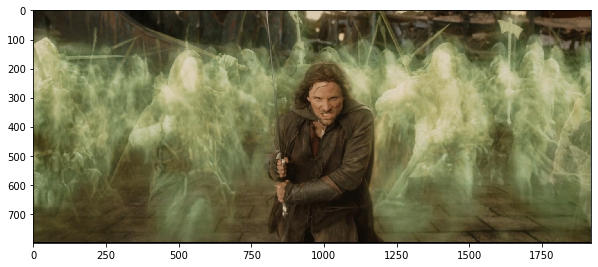

In [9]:
# Randomly select one of raw LOTR testing images
random_testing_image_path = raw_image_dir + os.sep + list_of_raw_images[randint(0,len(list_of_raw_images)-1)]

# Print selected image path
print("Selected image path: " + random_testing_image_path)

# Read selected image
image = cv2.imread(random_testing_image_path)

# Visualize selected image
plot_image(image)

# 3. Arranging the dataset

### 3.1. Define face extraction function

* First need to define face detection function:

In [10]:
# Apply previously implemented deep learning-based face detector to 
# localize faces in the input image

def detect_faces(image):
    # Convert image to string before sending it to flask api
    image = cv2.imencode('.jpg', image)[1].tostring()
    
    # Define heroku server url
    heroku_server_url = "https://face-detection-api-flask.herokuapp.com/detect"
    # Send request to heroku server
    response = requests.post(heroku_server_url, files={'image': image})
    # Send request to localhost server
    # response = requests.post('http://127.0.0.1:3000/detect', files={'image': image})
    
    # Convert response to json object (dictionary)
    response_json = response.json()
    # Convert response to json object (dictionary)
    detections = response_json["detections"]
    
    return detections

* Now define face extraction function:

In [13]:
# Extract faces from the images in raw_image_dir folder to "images/lotr/train/faces" folder

def extract_faces(raw_image_dir = ""):
    # Assign minimum confidence threshold for face detection result
    min_confidence = 30
    
    # Create export directory
    faces_dir = raw_image_dir + os.sep + ".." + os.sep + 'faces'
    os.makedirs(faces_dir, exist_ok=True)
    
    # Grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    image_paths = list(imutils.paths.list_images(raw_image_dir))
    
    index = 0
    # Loop over the image paths
    for (i, image_path) in enumerate(image_paths):
        # Extract the person name from the image path
        print("[INFO] processing image {}/{}".format(i + 1, len(image_paths)))
    
        # Load the image and then resize it
        image = cv2.imread(image_path)
        # Get image shape
        (image_height, image_width) = image.shape[:2]
        resized_image = cv2.resize(image, (300, 300))
        #image = resize(image, width=600)
    
        print("[INFO] performing face detection over api for: " + image_path.split("\\")[-1])
        detections = detect_faces(resized_image)
        #detections = detect_faces(image)
        
        # Ensure at least one face was found
        if len(detections) > 0:
            for detection in detections:
                # Extract the confidence (i.e., probability) associated with the
                # prediction 
                confidence = detection["prob"]
                
                # Get detection coords
                [start_x, start_y, end_x, end_y] = detection["rect"]
                # Correct the detections regions
                start_x = int(start_x/300*image_width)
                start_y = int(start_y/300*image_height)
                end_x = int(end_x/300*image_width)
                end_y = int(end_y/300*image_height)
                
                # Ensure that the detection with the largest probability also
                # means our minimum probability test (thus helping filter out
                # weak detections)
                if confidence > min_confidence:
                    # Extract the face ROI
                    face = image[start_y :end_y, start_x : end_x]
                    (fH, fW) = face.shape[:2]
                    
                    # Ensure the face width and height are sufficiently large
                    if fW < 20 or fH < 20:
                        continue
                    
                    face_path = raw_image_dir + os.sep + ".." + os.sep + 'faces' + os.sep + "face" + '_' + str(index) + ".jpg"
                    cv2.imwrite(face_path, face)
                    print("[INFO] face is extracted to: " + face_path)
                    index = index + 1

### 3.2. Extract faces from raw training images

In [14]:
# Get raw LOTR training images directory
raw_image_dir = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "raw"

# Extract faces to "images/lotr/train/faces" folder
extract_faces(raw_image_dir)

[INFO] quantifying faces...
[INFO] processing image 1/83
[INFO] performing face detection over api for: aragorn1.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_0.jpg
[INFO] processing image 2/83
[INFO] performing face detection over api for: aragorn13.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_1.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_2.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_3.jpg
[INFO] processing image 3/83
[INFO] performing face detection over api for: aragorn14.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_4.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_5.jpg
[INFO] processing image 4/83
[INFO] performing face detection over api for: aragorn2.jpg
[INFO] face is extracted to: images\lotr\train\raw\..\faces\face_6.jpg
[INFO] processing image 5/83
[INFO] performing face detection over api for: aragorn3.jpg
[INFO] face is extracted to:

### 3.3. Visualize extracted faces

In [15]:
# Get extracted faces directory
extracted_faces_dir = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "faces"

# Print extracted faces directory
print("Extracted faces directory: " + extracted_faces_dir + "\n")

# Get list of extracted faces
list_of_extracted_faces = os.listdir(extracted_faces_dir)

Extracted faces directory: images\lotr\train\faces



Selected image path: images\lotr\train\faces\face_30.jpg


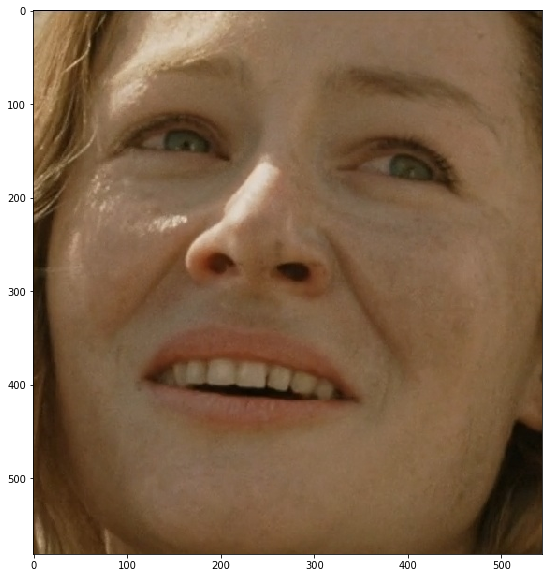

In [16]:
# Randomly select one of the extracted faces
random_index = randint(0,len(list_of_extracted_faces)-1)
random_extracted_face_path = extracted_faces_dir + os.sep + list_of_extracted_faces[random_index]

# Print selected image path
print("Selected image path: " + random_extracted_face_path)

# Read selected image
image = cv2.imread(random_extracted_face_path)

# Visualize selected image
plot_image(image)

### 3.3. Create several training sets using extracted faces

* By ignoring false postives (incorrect face detection regions), 5-10 face images should be selected per person. 

* For the sake of simplicity, I have arranged training sets with 2, 5 and 10 classes (persons) containing cropped faces of Gandalf, Legolas, Frodo, Gollum, and most of other LOTR characters.

Folder structure is given as:

<pre><code>
images/
│ 
└───lotr/
    │
    └───train/
        │
        └───<b>2_classes/</b>
        │   │
        │   └───gandalf/
        │   │
        │   └───other/
        │
        │
        └───<b>5_classes/</b>
        │   │
        │   └───aragorn/
        │   │
        │   └───gandalf/
        │   │
        │   └───gimli/
        │   │
        │   └───legolas/
        │   │
        │   └───other/
        │
        │    
        └───<b>10classes/</b>
            │
            └───aragorn/
            │
            └───frodo/
            │
            └───gandalf/
            │
            └───gimli/
            │
            └───gollum/
            │
            └───legolas/
            │
            └───other/
            │
            └───sam/
            │
            └───saruman/
            │
            └───theoden/
</code></pre>

### 3.4. Analyze one of the training sets

Let's analyze the training set with 5 classes:

In [17]:
# Select one of the training sets (2_classes, 5_classes or 10_classes)
training_set_name = "10_classes"

# Print folder path
training_set_dir = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + training_set_name
print("Selected training set directory: " + training_set_dir)

Selected training set directory: images\lotr\train\10_classes


In [18]:
# Print target class names (persons)
target_class_names = os.listdir(training_set_dir)
print("Target class names: " + str(target_class_names))

Target class names: ['aragorn', 'frodo', 'gandalf', 'gimli', 'gollum', 'legolas', 'other', 'sam', 'saruman', 'theoden']


Selected image path: images\lotr\train\10_classes\gandalf\face_38.jpg


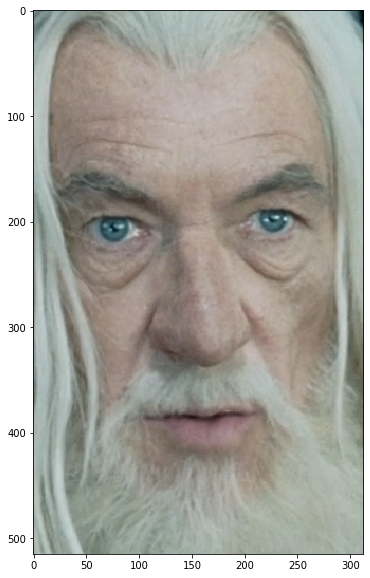

In [19]:
# Select one of the available target classes
target_class_name = "gandalf"

# Get list of extracted faces for chosen target class
target_class_dir = training_set_dir + os.sep + target_class_name
list_of_extracted_faces = os.listdir(target_class_dir)

# Randomly select one of the face images
random_index = randint(0,len(list_of_extracted_faces)-1)
random_extracted_face_path = target_class_dir + os.sep + list_of_extracted_faces[random_index]

# Print selected image path
print("Selected image path: " + random_extracted_face_path)

# Read selected image
image = cv2.imread(random_extracted_face_path)

# Visualize selected image
plot_image(image)

# 4. Facial embedding extraction

First, we need to define a function that loads facial embedding extraction model and extracts embedding vector from all face images:

In [20]:
# Extract facial feature embeddings from the face images that we arranged in previous part

def extract_embeddings(classes_dir = "", embeddings_path = ""):
    # Get models directory
    models_dir = "models" + os.sep
    
    # load our serialized face embedding model from disk
    print("[INFO] loading face embedding extractor...")
    face_embedding_model_filename = "openface_nn4.small2.v1.t7"
    embedder = cv2.dnn.readNetFromTorch(models_dir + face_embedding_model_filename)
    
    # Grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    image_paths = list(paths.list_images(classes_dir))

    # Initialize our lists of extracted facial embeddings and
    # corresponding character names
    known_embeddings = []
    known_names = []
    
    # Initialize the total number of faces processed
    total = 0
    
    # Loop over the image paths
    for (i, image_path) in enumerate(image_paths):
        
        # Extract the person name from the image path
        name = image_path.split(os.sep)[-2]
        
        print("[INFO] processing image {}/{}".format(i + 1, len(image_paths)) + " - " + image_path.split(os.sep)[-1])
        
        # Load the image
        face = cv2.imread(image_path)

        # Construct a blob for the face ROI, then pass the blob
        # through our face embedding model to obtain the 128-d
        # quantification of the face
        face_blob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
             (0, 0, 0), swapRB=True, crop=False)
        embedder.setInput(face_blob)
        vec = embedder.forward()

        # Add the name of the person + corresponding face
        # embedding to their respective lists
        known_names.append(name)
        known_embeddings.append(vec.flatten())
        total += 1
    
    # Dump the facial embeddings + names to disk as pickle
    print("[INFO] serializing {} encodings...".format(total))
    data = {"embeddings": known_embeddings, "names": known_names}
    with open(embeddings_path, "wb") as write_file:
        pickle.dump(data, write_file)

* Perform embedding extraction for 2_classes set and save the embeddings as pickle:

In [21]:
classes_dir_2c = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "2_classes"
embeddings_path_2c = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "embeddings_2c.pickle"
extract_embeddings(classes_dir_2c, embeddings_path_2c)

[INFO] loading face embedding extractor...
[INFO] quantifying faces...
[INFO] processing image 1/9 - face_37.jpg
[INFO] processing image 2/9 - face_38.jpg
[INFO] processing image 3/9 - face_42.jpg
[INFO] processing image 4/9 - face_43.jpg
[INFO] processing image 5/9 - face_19.jpg
[INFO] processing image 6/9 - face_22.jpg
[INFO] processing image 7/9 - face_80.jpg
[INFO] processing image 8/9 - face_81.jpg
[INFO] processing image 9/9 - face_84.jpg
[INFO] serializing 9 encodings...


* Perform embedding extraction for 5_classes set and save the embeddings as pickle:

In [22]:
classes_dir_5c = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "5_classes"
embeddings_path_5c = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "embeddings_5c.pickle"
extract_embeddings(classes_dir_5c, embeddings_path_5c)

[INFO] loading face embedding extractor...
[INFO] quantifying faces...
[INFO] processing image 1/27 - face_0.jpg
[INFO] processing image 2/27 - face_1.jpg
[INFO] processing image 3/27 - face_10.jpg
[INFO] processing image 4/27 - face_4.jpg
[INFO] processing image 5/27 - face_6.jpg
[INFO] processing image 6/27 - face_37.jpg
[INFO] processing image 7/27 - face_38.jpg
[INFO] processing image 8/27 - face_42.jpg
[INFO] processing image 9/27 - face_43.jpg
[INFO] processing image 10/27 - face_49.jpg
[INFO] processing image 11/27 - face_50.jpg
[INFO] processing image 12/27 - face_51.jpg
[INFO] processing image 13/27 - face_52.jpg
[INFO] processing image 14/27 - face_54.jpg
[INFO] processing image 15/27 - face_14.jpg
[INFO] processing image 16/27 - face_70.jpg
[INFO] processing image 17/27 - face_71.jpg
[INFO] processing image 18/27 - face_72.jpg
[INFO] processing image 19/27 - face_75.jpg
[INFO] processing image 20/27 - face_77.jpg
[INFO] processing image 21/27 - face_78.jpg
[INFO] processing 

* Perform embedding extraction for 10_classes set and save the embeddings as pickle:

In [23]:
classes_dir_10c = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "10_classes"
embeddings_path_10c = "images" + os.sep + "lotr" + os.sep + "train" + os.sep + "embeddings_10c.pickle"
extract_embeddings(classes_dir_10c, embeddings_path_10c)

[INFO] loading face embedding extractor...
[INFO] quantifying faces...
[INFO] processing image 1/54 - face_0.jpg
[INFO] processing image 2/54 - face_1.jpg
[INFO] processing image 3/54 - face_10.jpg
[INFO] processing image 4/54 - face_4.jpg
[INFO] processing image 5/54 - face_6.jpg
[INFO] processing image 6/54 - face_31.jpg
[INFO] processing image 7/54 - face_32.jpg
[INFO] processing image 8/54 - face_33.jpg
[INFO] processing image 9/54 - face_34.jpg
[INFO] processing image 10/54 - face_36.jpg
[INFO] processing image 11/54 - face_38.jpg
[INFO] processing image 12/54 - face_37.jpg
[INFO] processing image 13/54 - face_38.jpg
[INFO] processing image 14/54 - face_42.jpg
[INFO] processing image 15/54 - face_43.jpg
[INFO] processing image 16/54 - face_49.jpg
[INFO] processing image 17/54 - face_50.jpg
[INFO] processing image 18/54 - face_51.jpg
[INFO] processing image 19/54 - face_52.jpg
[INFO] processing image 20/54 - face_54.jpg
[INFO] processing image 21/54 - face_55.jpg
[INFO] processing 

# 5. Train multiple classifiers for face recognition

### 5.1. Define classifiers

* Define Naive Bayes classifier with Gaussian prior:

In [24]:
def train_nb_model(embeddings_path = "", classifier_model_path = "", label_encoder_path = ""):
    # Trains a NB classifier using embedding file from "embeddings_path", 
    # then saves the trained model as "classifier_model_path" and 
    # label encoding as "label_encoder_path".
    
    # Load the face embeddings
    print("[INFO] loading face embeddings...")
    data = pickle.loads(open(embeddings_path, "rb").read())
    
    # Encode the labels
    print("[INFO] encoding labels...")
    le = LabelEncoder()
    labels = le.fit_transform(data["names"])
    
    # Train the model used to accept the 128-d embeddings of the face and
    # then produce the actual face recognition
    print("[INFO] training model...")
    recognizer = GaussianNB()
    
    recognizer.fit(data["embeddings"], 
                   labels)
    
    print("[INFO] saving model...")
    # Write the actual face recognition model to disk as pickle
    with open(classifier_model_path, "wb") as write_file:
        pickle.dump(recognizer, write_file)
    
    # Write the label encoder to disk as pickle
    with open(label_encoder_path, "wb") as write_file:
        pickle.dump(le, write_file)

* Define Support Vector Machine classifier in "one vs rest" behaviour:

In [25]:
def train_svm_model(embeddings_path = "", classifier_model_path = "", label_encoder_path = ""):
    # Trains a SVM classifier using embedding file from "embeddings_path", 
    # then saves the trained model as "classifier_model_path" and 
    # label encoding as "label_encoder_path".
    
    # Load the face embeddings
    print("[INFO] loading face embeddings...")
    data = pickle.loads(open(embeddings_path, "rb").read())
    
    # Encode the labels
    print("[INFO] encoding labels...")
    le = LabelEncoder()
    labels = le.fit_transform(data["names"])
    
    # Train the model used to accept the 128-d embeddings of the face and
    # then produce the actual face recognition
    print("[INFO] training model...")
    recognizer = SVC(C=1, 
                     kernel="linear", 
                     decision_function_shape='ovr', 
                     probability=True)
    
    recognizer.fit(data["embeddings"], 
                   labels)
    
    print("[INFO] saving model...")
    # Write the actual face recognition model to disk as pickle
    with open(classifier_model_path, "wb") as write_file:
        pickle.dump(recognizer, write_file)
    
    # Write the label encoder to disk as pickle
    with open(label_encoder_path, "wb") as write_file:
        pickle.dump(le, write_file)

* Define Multi Layer Perceptron (2-Layer) based classifier:

In [26]:
def create_mlp_model(optimizer='adam', neuron_number=50, lr=0.001, class_number=5):
    # Build function for keras/tensorflow based multi layer perceptron implementation
    model = Sequential()
    model.add(Dense(neuron_number, input_dim=128, activation='relu'))
    model.add(Dense(neuron_number, activation='relu'))
    model.add(Dense(class_number, activation='softmax'))
    optimizer = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def train_mlp_model(embeddings_path = "", classifier_model_path = "", label_encoder_path = ""):
    # Trains a MLP classifier using embedding file from "embeddings_path", 
    # then saves the trained model as "classifier_model_path" and 
    # label encoding as "label_encoder_path".
    
    # Load the face embeddings
    print("[INFO] loading face embeddings...")
    data = pickle.loads(open(embeddings_path, "rb").read())
    
    # Encode the labels
    print("[INFO] encoding labels...")
    le = LabelEncoder()
    labels = le.fit_transform(data["names"])
    class_number = len(set(labels))
    
    # Reshape the data
    embedding_mtx = np.zeros([len(data["embeddings"]),len(data["embeddings"][0])])
    for ind in range(1,len(data["embeddings"])):
        embedding_mtx[ind,:] = data["embeddings"][ind]
        
    # Train the model used to accept the 128-d embeddings of the face and
    # then produce the actual face recognition
    print("[INFO] training model...")
    recognizer = KerasClassifier(build_fn=create_mlp_model, 
                                 epochs=450, 
                                 batch_size=64, 
                                 verbose=1,
                                 neuron_number = 32,
                                 lr = 1e-3,
                                 class_number = class_number)
    
    recognizer.fit(embedding_mtx, 
                   labels)
    
    print("[INFO] saving model...")
    # Write the actual face recognition model to disk as pickle
    with open(classifier_model_path, "wb") as write_file:
        pickle.dump(recognizer, write_file)
    
    # Write the label encoder to disk as pickle
    with open(label_encoder_path, "wb") as write_file:
        pickle.dump(le, write_file)

### 5.2. Train the classifiers using previously extracted facial embeddings

#### 5.2.1. Train Naive Bayes

* Train Naive Bayes classidier for 2_classes set:

In [27]:
embeddings_path = embeddings_path_2c
classifier_model_path = "models" + os.sep + "lotr_nb_2c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_nb_2c_labelencoder.pickle"
train_nb_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] saving model...


* Train Naive Bayes classidier for 5_classes set:

In [28]:
embeddings_path = embeddings_path_5c
classifier_model_path = "models" + os.sep + "lotr_nb_5c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_nb_5c_labelencoder.pickle"
train_nb_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] saving model...


* Train Naive Bayes classidier for 10_classes set:

In [29]:
embeddings_path = embeddings_path_10c
classifier_model_path = "models" + os.sep + "lotr_nb_10c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_nb_10c_labelencoder.pickle"
train_nb_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] saving model...


#### 5.2.2. Train Support Vector Machine

* Train Support Vector Machine classifier for 2_classes set:

In [30]:
embeddings_path = embeddings_path_2c
classifier_model_path = "models" + os.sep + "lotr_svm_2c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_svm_2c_labelencoder.pickle"
train_svm_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] saving model...


* Train Support Vector Machine classifier for 5_classes set:

In [31]:
embeddings_path = embeddings_path_5c
classifier_model_path = "models" + os.sep + "lotr_svm_5c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_svm_5c_labelencoder.pickle"
train_svm_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] saving model...


* Train Support Vector Machine classifier for 10_classes set:

In [32]:
embeddings_path = embeddings_path_10c
classifier_model_path = "models" + os.sep + "lotr_svm_10c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_svm_10c_labelencoder.pickle"
train_svm_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] saving model...


#### 5.2.3. Train Multi Layer Perceptron

* Train Multi Layer Perceptron classifier for 2_classes set:

In [33]:
embeddings_path = embeddings_path_2c
classifier_model_path = "models" + os.sep + "lotr_mlp_2c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_mlp_2c_labelencoder.pickle"
train_mlp_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/450
9/9 [==============================] - 0s 24ms/step - loss: 0.6955 - acc: 0.5556
Epoch 2/450
9/9 [==============================] - 0s 0us/step - loss: 0.6821 - acc: 0.6667
Epoch 3/450
9/9 [==============================] - 0s 109us/step - loss: 0.6693 - acc: 0.7778
Epoch 4/450
9/9 [==============================] - 0s 111us/step - loss: 0.6584 - acc: 0.8889
Epoch 5/450
9/9 [==============================] - 0s 111us/step - loss: 0.6476 - acc: 0.8889
Epoch 6/450
9/9 [==============================] - 0s 111us/step - loss: 0.6371 - acc: 0.8889
Epoch 7/450
9/9 [==============================] - 0s 111us/step - loss: 0.6271 - acc: 0.8889
Epoch 8/450
9/9 [==============================] - 0s 0us/step - loss: 0.6172 - acc: 0.8889
Epoch 9/450
9/9 [==============================] - 0s 111us/step - l

* Train Multi Layer Perceptron classifier for 5_classes set:

In [34]:
embeddings_path = embeddings_path_5c
classifier_model_path = "models" + os.sep + "lotr_mlp_5c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_mlp_5c_labelencoder.pickle"
train_mlp_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
Epoch 1/450
27/27 [==============================] - 0s 5ms/step - loss: 1.6184 - acc: 0.1852
Epoch 2/450
27/27 [==============================] - 0s 36us/step - loss: 1.6120 - acc: 0.1852
Epoch 3/450
27/27 [==============================] - 0s 37us/step - loss: 1.6050 - acc: 0.2222
Epoch 4/450
27/27 [==============================] - 0s 37us/step - loss: 1.5978 - acc: 0.2222
Epoch 5/450
27/27 [==============================] - 0s 0us/step - loss: 1.5907 - acc: 0.2222
Epoch 6/450
27/27 [==============================] - 0s 37us/step - loss: 1.5836 - acc: 0.2222
Epoch 7/450
27/27 [==============================] - 0s 37us/step - loss: 1.5764 - acc: 0.2593
Epoch 8/450
27/27 [==============================] - 0s 37us/step - loss: 1.5693 - acc: 0.3333
Epoch 9/450
27/27 [==============================] - 0s 37us/step - loss: 1.5620 - acc: 0.3333
Epoch 10/450
27/27 [==============================] - 0s 37us/

* Train Multi Layer Perceptron classifier for 10_classes set:

In [35]:
embeddings_path = embeddings_path_10c
classifier_model_path = "models" + os.sep + "lotr_mlp_10c_recognizer.pickle"
label_encoder_path = "models" + os.sep + "lotr_mlp_10c_labelencoder.pickle"
train_mlp_model(embeddings_path, classifier_model_path, label_encoder_path)

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
Epoch 1/450
54/54 [==============================] - 0s 3ms/step - loss: 2.3193 - acc: 0.0926
Epoch 2/450
54/54 [==============================] - 0s 19us/step - loss: 2.3130 - acc: 0.0741
Epoch 3/450
54/54 [==============================] - 0s 19us/step - loss: 2.3059 - acc: 0.0741
Epoch 4/450
54/54 [==============================] - 0s 0us/step - loss: 2.2986 - acc: 0.0741
Epoch 5/450
54/54 [==============================] - 0s 19us/step - loss: 2.2912 - acc: 0.0926
Epoch 6/450
54/54 [==============================] - 0s 19us/step - loss: 2.2839 - acc: 0.0926
Epoch 7/450
54/54 [==============================] - 0s 0us/step - loss: 2.2767 - acc: 0.0926
Epoch 8/450
54/54 [==============================] - 0s 19us/step - loss: 2.2694 - acc: 0.1111
Epoch 9/450
54/54 [==============================] - 0s 37us/step - loss: 2.2624 - acc: 0.2037
Epoch 10/450
54/54 [==============================] - 0s 19us/s

# 6. Perform face recognition

### 6.1. Define face recognition function

In [36]:
def recognize_faces(image, classifier_model_path, label_encoder_path):
    '''Recognize faces in an image'''
    faces_list = []
    min_detection_confidence = 20 # percent
    
    # Load our serialized face embedding model from disk
    print("[INFO] loading face recognizer...")
    models_dir = "models" + os.sep
    face_embedding_model_filename = "openface_nn4.small2.v1.t7"
    embedder = cv2.dnn.readNetFromTorch(models_dir + face_embedding_model_filename)
    
    # Load the actual face recognition model along with the label encoder
    recognizer = pickle.loads(open(classifier_model_path, "rb").read())
    label_encoder = pickle.loads(open(label_encoder_path, "rb").read())
    
    print("[INFO] performing face detection over api...")
    detections = detect_faces(image)
    
    print("[INFO] performing face recognition...")
    # Loop over the detections
    for detection in detections:
        # Get detection region
        [start_x, start_y, end_x, end_y] = detection["rect"]
        # Extract the confidence (i.e., probability) associated with the
        # prediction 
        detection_confidence = detection["prob"]
        
        # Filter out weak detections
        if detection_confidence > min_detection_confidence:
            # Extract the face ROI
            face = image[start_y:end_y, start_x:end_x]
            (fH, fW) = face.shape[:2]
            
            # Ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue
            
            # Construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            face_blob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
                 (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(face_blob)
            vec = embedder.forward()
    
            # Perform classification to recognize the face
            preds = recognizer.predict_proba(vec)[0]
            j = np.argmax(preds)
            # Get recognition confidence
            recognition_confidence = preds[j]
            # Convert it to a native python variable (float)
            recognition_confidence = recognition_confidence.item()
            # Get recognition class name
            name = label_encoder.classes_[j]
            # Convert it to a native python variable (str)
            name = name.item()
    
            # Append results to list
            face_dict = {}
            face_dict['rect'] = [start_x, start_y, end_x, end_y]
            face_dict['detection_prob'] = detection_confidence
            face_dict['recognition_prob'] = recognition_confidence * 100
            face_dict['name'] = name
            faces_list.append(face_dict)
            
    # Return the face image area, the face rectangle, and face name
    return faces_list

### 6.2. Perform face recognition with desired configuration

#### 6.2.1. Select one of the trained models:
    * lotr_nb_2c_recognizer.pickle
    * lotr_nb_5c_recognizer.pickle
    * lotr_nb_10c_recognizer.pickle
    * lotr_svm_2c_recognizer.pickle
    * lotr_svm_5c_recognizer.pickle
    * lotr_svm_10c_recognizer.pickle
    * lotr_mlp_2c_recognizer.pickle
    * lotr_mlp_5c_recognizer.pickle
    * lotr_mlp_10c_recognizer.pickle

In [37]:
classifier_model_path = "models" + os.sep + "lotr_mlp_10c_recognizer.pickle"

#### 6.2.2. Select related label encoder:
    * lotr_nb_2c_labelencoder.pickle
    * lotr_nb_5c_labelencoder.pickle
    * lotr_nb_10c_labelencoder.pickle
    * lotr_svm_2c_labelencoder.pickle
    * lotr_svm_5c_labelencoder.pickle
    * lotr_svm_10c_labelencoder.pickle
    * lotr_mlp_2c_labelencoder.pickle
    * lotr_mlp_5c_labelencoder.pickle
    * lotr_mlp_10c_labelencoder.pickle

In [38]:
label_encoder_path = "models" + os.sep + "lotr_mlp_10c_labelencoder.pickle"

#### 6.2.3. List LOTR test images:

In [39]:
# Get raw LOTR testing images directory
raw_image_dir = "images" + os.sep + "lotr" + os.sep + "test" + os.sep + "raw" + os.sep

# Print raw LOTR testing images directory
print("Raw LOTR training images directory: " + raw_image_dir + "\n")

# Get list of raw LOTR testing images
list_of_raw_images = os.listdir(raw_image_dir)

# Print list of raw LOTR testing images
print("List of raw LOTR training images: \n" + str(list_of_raw_images))

Raw LOTR training images directory: images\lotr\test\raw\

List of raw LOTR training images: 
['aragorn10.jpg', 'aragorn11.jpg', 'aragorn12.jpg', 'arwen4.jpg', 'gandalf11.jpg', 'gandalf6.jpg', 'gimli14.jpg', 'gollum4.jpg', 'legolas11.jpg', 'legolas6.jpg', 'legolas7.jpg', 'other8.jpg', 'sam12.jpg', 'saruman1.jpg', 'theoden6.jpg']


#### 6.2.4. Select test image and perform face recognition:

[INFO] loading face recognizer...
[INFO] performing face detection over api...
[INFO] performing face recognition...
1/1 [==============================] - 0s 42ms/step


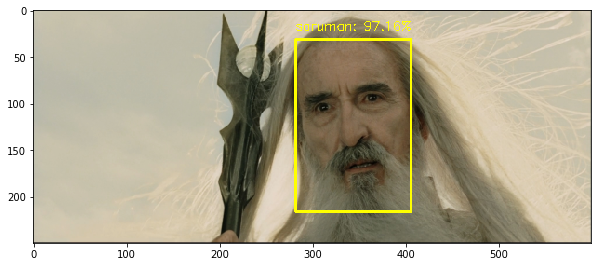

In [43]:
file_path = raw_image_dir + "saruman1.jpg"
image = cv2.imread(file_path)
image = imutils.resize(image, width=600)
recognitions = recognize_faces(image, classifier_model_path, label_encoder_path)

draw_rectangles(image, recognitions)
plot_image(image)